In [1]:
!pip install -U langgraph langchain-google-genai yfinance
!pip install fpdf

  Preparing metadata (setup.py) ... done
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40704 sha256=4e8448f8601644497bad0e582824ae55d187b97916d1990db98395fb4790788e
  Stored in directory: /root/.cache/pip/wheels/6e/62/11/dc73d78e40a218ad52e7451f30166e94491be013a7850b5d75
Successfully built fpdf


In [2]:
import os
import yfinance as yf
from typing import Literal, TypedDict, Dict, Any
from langgraph.graph import StateGraph, END
from langchain_google_genai import ChatGoogleGenerativeAI
from google.colab import userdata

# --- 0. CONFIGURATION & AUTH ---
os.environ["GOOGLE_API_KEY"] = userdata.get("GOOGLE_API_KEY")

# Initialize Gemini 2.0 Flash (Fast & Free)
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

# 1. Expand the State to handle complex financial data
class FinanceState(TypedDict):
    ticker: str
    fundamentals: Dict[str, Any]
    sentiment: str
    analyst_targets: Dict[str, Any]
    final_report: str

def sentiment_agent(state: FinanceState):
    print(f"---SENTIMENT AGENT: Researching {state['ticker']}---")
    stock = yf.Ticker(state['ticker'])
    news_list = stock.news

    # Defensive headline extraction
    headlines = []
    if news_list:
        for article in news_list[:5]:
            title = article.get('title') or article.get('headline') or "No Title"
            headlines.append(title)

    sentiment_text = "No recent public news found."
    if headlines:
        prompt = f"Analyze market sentiment for {state['ticker']} headlines: {headlines}"
        sentiment_text = llm.invoke(prompt).content

    return {"sentiment": sentiment_text}

In [3]:

# --- 2. THE ROUTER (The "Brain") ---

def research_router(state: FinanceState) -> Literal["public_path", "private_path"]:
    """Decides if the company has public market data."""
    stock = yf.Ticker(state['ticker'])
    # Check if we can get a current price; if not, it's likely private or delisted
    if stock.info.get('currentPrice'):
        return "public_path"
    else:
        return "private_path"

# --- 3. THE SPECIALIZED NODES ---

def fundamental_agent(state: FinanceState):
    print(f"---FUNDAMENTAL AGENT: Analyzing {state['ticker']}---")
    stock = yf.Ticker(state['ticker'])
    info = stock.info
    # Pulling specific ratios for the resume-ready look
    data = {
        "revenue_growth": info.get("revenueGrowth"),
        "debt_to_equity": info.get("debtToEquity"),
        "free_cashflow": info.get("freeCashflow"),
        "operating_margins": info.get("operatingMargins")
    }
    return {"fundamentals": data}

def quant_agent(state: FinanceState):
    print(f"---QUANT AGENT: Fetching Price Targets---")
    stock = yf.Ticker(state['ticker'])
    info = stock.info
    targets = {
        "current_price": info.get("currentPrice"),
        "target_mean": info.get("targetMeanPrice"),
        "recommendation": info.get("recommendationKey") # e.g., 'buy'
    }
    return {"analyst_targets": targets}


def lead_analyst(state: FinanceState):
    print(f"---LEAD ANALYST: Synthesizing Report---")

    # Use .get() with fallbacks so it never crashes
    fundamentals = state.get('fundamentals', 'No fundamental data available (Private Company)')
    targets = state.get('analyst_targets', 'No analyst targets available')
    sentiment = state.get('sentiment', 'No sentiment data available')

    prompt = f"""
    You are a Senior Investment Lead. Synthesize this data for {state['ticker']}:

    1. Fundamentals: {fundamentals}
    2. Analyst Targets: {targets}
    3. News Sentiment: {sentiment}

    Provide a professional 'Investment Thesis'. If data is missing because the company is private,
    focus entirely on the sentiment and the 'Narrative' of the company.
    """
    response = llm.invoke(prompt)
    return {"final_report": response.content}

# --- 4. THE GRAPH WITH CONDITIONAL EDGES ---

builder = StateGraph(FinanceState)

builder.add_node("fundamentals", fundamental_agent)
builder.add_node("quant", quant_agent)
builder.add_node("sentiment", sentiment_agent)
builder.add_node("lead_analyst", lead_analyst)

builder.set_conditional_entry_point(
    research_router,
    {
        "public_path": "fundamentals",
        "private_path": "sentiment"
    }
)

builder.add_edge("fundamentals", "quant")
builder.add_edge("quant", "sentiment")
builder.add_edge("sentiment", "lead_analyst")
builder.add_edge("lead_analyst", END)

invest_bot = builder.compile()



# Define Public Path sequence
builder.add_edge("fundamentals", "quant")
builder.add_edge("quant", "sentiment")
builder.add_edge("sentiment", "lead_analyst")

# Define Private Path exit (Sentiment already added above, just need the exit)
builder.add_edge("lead_analyst", END)

invest_bot = builder.compile()

In [8]:
from fpdf import FPDF

def generate_pdf_report(ticker, report_text):
    pdf = FPDF()
    pdf.add_page()

    # Title
    pdf.set_font("Arial", 'B', 16)
    pdf.cell(200, 10, txt=f"Investment Research Report: {ticker}", ln=True, align='C')
    pdf.ln(10)

    # Body
    pdf.set_font("Arial", size=12)
    # Multi_cell handles word wrapping automatically
    pdf.multi_cell(0, 10, txt=report_text)

    filename = f"{ticker}_Research_Report.pdf"
    pdf.output(filename)
    return filename

# --- CLEAN EXECUTION ---
print(f"--- STARTING AUTONOMOUS RESEARCH FOR: OpenAI ---")

try:
    # We pass the initial state to ensure no KeyErrors
    result = invest_bot.invoke({
        "ticker": "NVDA",
        "fundamentals": {},
        "analyst_targets": {},
        "sentiment": ""
    })

    final_thesis = result['final_report']

    # Generate the PDF
    file_path = generate_pdf_report("NVDA", final_thesis)

    print("\n" + "="*30)
    print("ANALYSIS COMPLETE")
    print("="*30)
    print(f"PDF Generated: {file_path}")
    print("\nFinal Thesis Preview:\n", final_thesis[:500] + "...")

except Exception as e:
    print(f"Agent encountered an error: {e}")

--- STARTING AUTONOMOUS RESEARCH FOR: OpenAI ---
---FUNDAMENTAL AGENT: Analyzing NVDA---
---QUANT AGENT: Fetching Price Targets---
---SENTIMENT AGENT: Researching NVDA---
---LEAD ANALYST: Synthesizing Report---

ANALYSIS COMPLETE
PDF Generated: NVDA_Research_Report.pdf

Final Thesis Preview:
 ## NVDA Investment Thesis: Strong Fundamentals, Bullish Analyst Sentiment, but Sentiment Analysis Inconclusive

**Executive Summary:**

NVIDIA (NVDA) presents a compelling investment opportunity based on its robust fundamentals, strong analyst recommendations, and significant growth potential. However, the lack of meaningful news sentiment data necessitates caution and further investigation.

**Investment Thesis:**

*   **Strong Financial Foundation:** NVDA boasts impressive financial metrics. A...


In [5]:
# # Test 1: Public Company (Full Path)
# print("--- TESTING NVIDIA (PUBLIC) ---")
# print(invest_bot.invoke({"ticker": "NVDA"})['final_report'])

# # Test 2: Private/Non-Ticker (Short Path)
# print("\n--- TESTING A PRIVATE NAME (NEWS ONLY) ---")
# # Note: yf might return news for a name even if no stock price exists
# print(invest_bot.invoke({"ticker": "OpenAI"})['final_report'])

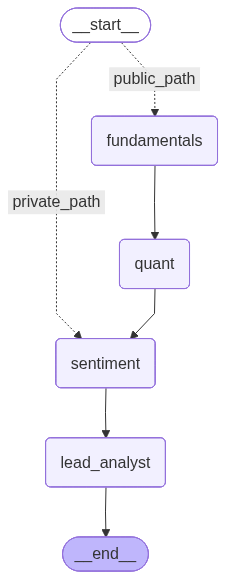

In [6]:
from IPython.display import Image, display

# This generates a visual flow-chart of your agent!
display(Image(invest_bot.get_graph().draw_mermaid_png()))